**6/30/21**

The purpose of this notebook is to compare the results of the 16S_Sample-Matched databases and the 16S_Reference database. I'm particularly interested in how the number of bacterial and human PSMs change when you use a 16S_Reference database, and what types of proteins you identify if you include protein sequences from all strains in your database.

In [1]:
from elliot_utils import *
initWithReference()

In [2]:
analysisPath = Path.cwd().joinpath('analysis_files/reference_genome_db/')
figPath = Path.cwd().joinpath('figures/reference_genome_db/')

In [3]:
tResults = getOrderedFiles(TAILORED_RESULTS, '.tsv')
rResults = getOrderedFiles(Path.cwd().joinpath('../1-12-22_NextflowMSGF_Reference_Combined/output_refined_processed/'), '.tsv')

In [4]:
tHPeps = getFilteredPeptides(tResults, 'human')
tBPeps = getFilteredPeptides(tResults, 'bacteria')
rHPeps = getFilteredPeptides(rResults, 'human')
rBPeps = getFilteredPeptides(rResults, 'bacteria')

In [5]:
# Parsing function to pull out the number of a specified type of spectra in a sample.
def countSpectra(resultsList, lookFor, allowed=set()):
    counts = []
    countAll = False if len(allowed) > 0 else True
    allowedPeps = allowed.copy()
    for res in resultsList:
        with res.open(mode='r') as infile:
            reader = csv.reader(infile, delimiter='\t')
            count = 0
            for row in reader:
                protType = determineIDType(row)
                if protType == 'first':
                    continue
                if countAll:
                    allowedPeps.add(row[PEPTIDE])
                if not isSignificant(row):
                    break
                if protType == lookFor and row[PEPTIDE] in allowedPeps:
                    count += 1
        counts.append(count)
    return counts

In [6]:
tHPSMs = countSpectra(tResults, 'human', tHPeps)
tBPSMs = countSpectra(tResults, 'bacteria', tBPeps)
rHPSMs = countSpectra(rResults, 'human', rHPeps)
rBPSMs = countSpectra(rResults, 'bacteria', rBPeps)

In [12]:
# Get average ratio of Reference to Sample-Matched for bacterial PSMs
bactFoldChange = []
for i in range(len(tBPSMs)):
    bactFoldChange.append(rBPSMs[i] / tBPSMs[i])
bactAvg = sum(bactFoldChange) / len(bactFoldChange)
print(f'Average ratio Reference:Sample-Matched Bacterial PSMs: {bactAvg}')

Average ratio Reference:Sample-Matched Bacterial PSMs: 0.880581605686415


In [13]:
# Get average ratio of Reference to Sample-Matched for human PSMs
humanFoldChange = []
for i in range(len(tHPSMs)):
    humanFoldChange.append(rHPSMs[i] / tHPSMs[i])
humanAvg = sum(humanFoldChange) / len(humanFoldChange)
print(f'Average ratio Reference:Sample-Matched Human PSMs: {humanAvg}')

Average ratio Reference:Sample-Matched Human PSMs: 1.0236338914315717


In [14]:
# Get percent increase human PSMs for Reference -> Tailored
humanDifs = []
for i in range(len(tHPSMs)):
    humanDifs.append(((rHPSMs[i] - tHPSMs[i]) / tHPSMs[i]) * 100)
print(f'Avg percent increase human PSMs using Reference: {str(sum(humanDifs) / len(humanDifs))}%')

Avg percent increase human PSMs using Reference: 2.363389143157169%


In [15]:
# Get percent increase bacterial PSMs for Tailored -> Reference
bacterialDifs = []
for i in range(len(tBPSMs)):
    bacterialDifs.append(((tBPSMs[i] - rBPSMs[i]) / rBPSMs[i]) * 100)
print(f'Avg percent increase bacterial PSMs using Tailored: {str(sum(bacterialDifs) / len(bacterialDifs))}%')

Avg percent increase bacterial PSMs using Tailored: 18.952854206565952%


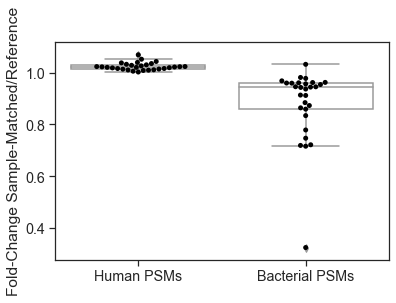

In [16]:
# Plot the fold-change for human and bacterial PSMs as boxplots
changePlotLabels = ['Human PSMs' for x in range(len(humanFoldChange))]
changePlotLabels.extend(['Bacterial PSMs' for x in range(len(bactFoldChange))])
changeDF = pd.DataFrame({'Fold-Change Sample-Matched/Reference':humanFoldChange + bactFoldChange, '':changePlotLabels})
sns.boxplot(x='', y='Fold-Change Sample-Matched/Reference', data=changeDF, color='white')
changeGraph = sns.swarmplot(x='', y='Fold-Change Sample-Matched/Reference', data=changeDF, color='black')
saveFig(changeGraph, figPath.joinpath('foldchange_human_bacterial_psms.png'))